# Introduction
In this exercise, we once again calculated the Value-at-Risk (VaR) of S&P500 returns. However, in this attempt, we jettisoned the assumption of normality. Instead, we will divide $r_t$ by the GARCH(1, 1) estimate of $\sigma_t$ and then use a mixture model to estimate the distribution of $r_t$. The mixture model contains normal pdf kernels to estimate the distribution. Our results were a substantial improvement over our previous VaR calculation.

This exercise builds-off of our previous work. We saved our estimates of the volatility $\sigma_t$ using a GARCH(1, 1) model. We used a mixture model to estimate the distribution $x_t = r_t/\sigma_t$ using $x_{t-1}, x_{t-2},\ldots, x_{t - 126}$. We then calculated the 5th percentile of this distribution and multiplied by $\sigma_t$ to estimate the Value-at-Risk at time $t$.

The mixture model best estimated the distribution of $x_t$ when we used three kernels. That is, we estimated the probability density function of $x_t = r_t/\sigma_t$ via
$$
f(x) = \sum_{k = 1}^K \frac{w_k}{\sqrt{2\pi\sigma_k^2}}\exp\left[-\frac{1}{2}\left(\frac{x-\mu_k}{\sigma_k}\right)^2\right],
$$
where $\sum_{k = 1}^K w_k = 1$, and found our distribution fit returns normalized best when $K = 3$. We used the Expectation Maximization (EM) algorithm to estimate the parameters of the mixture model. This lead to a substantial improvement in speed compared to the use of an optimizer. 

The date range for this exercise is 1995 to 2020, inclusive, and the data are at the daily frequency. Because there were many parameters to estimate, we broke our data into train and test sets. The training set contains observations until the end of 2008. Results for the train and test sets were very similar, which suggests our model did not over-fit the data. We obtained our original data from Yahoo Finance, but the data we used directly for this exercise were generated by us and is available on our GitHub.

# Packages and Setup

In [336]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import scipy.stats as stats
from scipy import integrate
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import datetime as dt
import os
os.chdir('/Users/charlesrambo/Desktop/GitHub data')


In [337]:
# Load S&P500 data
sp500 = pd.read_csv("GARCH_VaR_SP500.csv")

# Convert data column to date object
sp500['Date'] = pd.to_datetime(sp500['Date'], format = '%Y-%m-%d')

# Calculated normalized Ret
sp500['x'] = sp500['Ret']/sp500['sigma']

# Drop VaR
sp500.drop('VaR', axis = 1, inplace = True)

# Rename exceptions
sp500.rename(columns = {'Exception':'Excep_norm'}, inplace = True)

sp500.head()

,Date,Ret,sigma,Excep_norm,x
0,1995-01-03,-0.000348,0.004472,False,-0.077902
1,1995-01-04,0.003485,0.005296,False,0.658036
2,1995-01-05,-0.000803,0.006006,False,-0.133706
3,1995-01-06,0.000739,0.005890,False,0.125401
4,1995-01-09,0.000326,0.005839,False,0.055762


We included eight weeks of 2008 within our test set to estimate the distribution of normalized returns. Essentially, this means a small bit of the signal for the Value-at-Risk calculation of the test set uses train set data.

In [338]:
# Break into train and test
train = sp500.loc[sp500['Date'].dt.year <= 2008, :]

# Include some of 2008 in test to fit to distribution
test = sp500.loc[sp500['Date'] > train['Date'].max() - dt.timedelta(weeks = 8), :]

# Reset index on test so it starts at 0
test.reset_index(drop = True, inplace = True)

# Train Set Results
We graphed a histogram of $x_t$ and a normal distribution which best-fit parameter estimates. As can be seen, the distribution of $x_t$ is leptokurtic; returns near the mean occur more frequently than on a normal distribution and the tails are fatter. We will not use this result within our calculations, but it is included here to illustrate the problem with the assumption of normality.

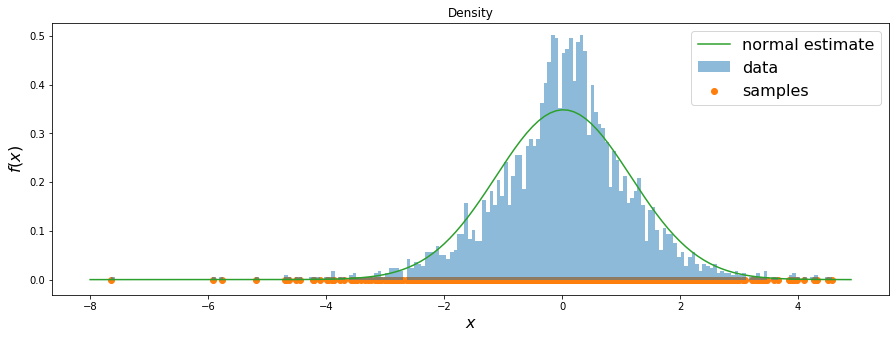

In [339]:
# Save array of default colors
colors = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# Fit to normal distribution
mu, sigma = stats.norm.fit(train['x'])

# Create array
x_arr = np.arange(-8, 5, 0.1)

# Get y-values for pdf with MLE parameters
y_norm = stats.norm.pdf(x_arr, loc = mu, scale = sigma)

# Plot estimated densities
fig, ax = plt.subplots(figsize = (15,5))

ax.hist(train['x'], 200, density = True, alpha = 0.50, label = 'data')
ax.scatter(train['x'], np.zeros(len(train['x'])), color = colors[1], label = 'samples')
ax.plot(x_arr, y_norm, color = colors[2], label = 'normal estimate')

ax.set_title('Density')
ax.set_xlabel(r'$x$', fontsize = 16)
ax.set_ylabel(r'$f(x)$', fontsize = 16)
ax.legend(fontsize = 16)

plt.show()

The value of $K$ determines the number of normal kernels to use for the mixture model. It is essentially a tuning parameter, much like $k$ in a $k$-means clustering algorithm. 

In [340]:
# The number of kernals
K = 3

def pdf(x, w, mu, sigma):
    
    y = 0
    
    for k in range(K):
    
        y += w[k] * stats.norm.pdf(x, loc = mu[k], scale = sigma[k])
        
    return y

def cdf(x, w, mu, sigma):
    
    y = 0
    
    for k in range(K):
        
        y += w[k] * stats.norm.cdf(x, loc = mu[k], scale = sigma[k])
        
    return y

def ppf(alpha, w, mu, sigma):
    
    x = fsolve(lambda x: cdf(x, w, mu, sigma) - alpha, x0 = 0, xtol = 1.5e-04)[0]
    
    return x
       

We will estimate the parameters of the mixture model using the EM algorithm. This is a very popular algorithm in machine learning. It is often used for clustering. See the [Wikipedia page](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm) for more detail.

In [341]:
def cal_em_pars(x):
    
    # Initialize parameters
    w = np.repeat(1/K, K)
    sigma = np.repeat(2/K * np.std(x), K)
    mu = stats.norm.rvs(loc = np.mean(x), scale = np.std(x), size = K)
    
    # Calculate other values needed for the loop
    n = len(x) 
    s = 1
    Q = -np.Inf
    
    # Choose how much improvement in log likelihood value is trivial
    epsilon = 10**-6
    
    # Turned to true when relative change in Q less than epsilon
    stop = False

    # Run algorithm
    while stop == False:
    
        # Initialize v
        v = np.zeros((n, K))
    
        # Calculate values for v in this iteration
        for k in range(K):
            v[: , k] = np.log(w[k]) + stats.norm.logpdf(x, loc = mu[k], scale = sigma[k])
    
        # Calculate max of each row
        v_max = np.reshape(np.max(v, axis = 1), newshape = (n, 1))
    
        # Calculate sum of each row
        v_sum = np.reshape(np.sum(np.exp(v - v_max), axis = 1), newshape = (n, 1))
    
        # Convert v-values to maintain numerical stability
        v = np.exp(v - v_max)/v_sum
    
        # Take the average of each column to obtain weights
        w = np.mean(v, axis = 0)
    
        # Estimate mean and standard deviations
        for k in range(K):   
            mu[k] = np.sum(v[:, k] * x)/np.sum(v[:, k])
            sigma[k] = np.sum(v[:, k] * (x - mu[k])**2)
            sigma[k] = np.sqrt(sigma[k]/np.sum(v[:, k]))
        
        # Initialize Qn
        Qn = 0
        
        for k in range(K):   
            Qn += np.sum(v[:, k] * (np.log(w[k]) + stats.norm.logpdf(x, loc = mu[k], scale = sigma[k]))) 
    
        # Check to see if improvement is trivial; also stop if over 20 iterations 
        if (np.abs(1 - Q/Qn) < epsilon)| (s > 20):
        
            stop = True
           
        Q = Qn
        s += 1
         
    return w, mu, sigma


We will loop over the observations in our training set. Most often, the previous 126 business days of observations with be used. However, we created an expanding window. When fewer days are available, only those days will be used. We started our estimation of the Value-at-Risk 45 business days after the first observation in our training set because we would most likely get poor results if we estimated all six parameters with less data.

In [342]:
# Save results
w_out = np.zeros((1, K))
mu_out = np.zeros((1, K))
sigma_out = np.zeros((1, K))

# Record window
window = 126

for i in train.index[45:]:
    
    start = int(np.max([i - window, 0]))
    stop = i - 1
    
    x = train.loc[start:stop, 'x'].values
    
    w, mu, sigma = cal_em_pars(x)
    
    # Start VaR calculation; still need to denormalize
    train.loc[i, 'VaR'] = 0 - ppf(0.05, w, mu, sigma)
    
    w_out = np.concatenate([w_out, [w]], axis = 0)
    mu_out = np.concatenate([mu_out, [mu]], axis = 0)
    sigma_out = np.concatenate([sigma_out, [sigma]], axis = 0)

# Remove row of zeros
w_out = w_out[1:]
mu_out = mu_out[1:]
sigma_out = sigma_out[1:]
    
# Denormalize
train['VaR'] = train['sigma'] * train['VaR']
    
# Obtain days when there is an exception
train['Exception'] = 0 - train['VaR'] > train['Ret']

train.dropna(axis = 0, inplace = True)
train.reset_index(drop = True, inplace = True)
train.head()

/Users/charlesrambo/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/charlesrambo/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/charlesrambo/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1782: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarra

,Date,Ret,sigma,Excep_norm,x,VaR,Exception
0,1995-03-08,0.002116,0.007403,False,0.285788,0.007347,False
1,1995-03-09,0.000041,0.006612,False,0.006258,0.006789,False
2,1995-03-10,0.013267,0.006123,False,2.166880,0.006075,False
3,1995-03-13,0.000980,0.010266,False,0.095498,0.009997,False
4,1995-03-14,0.005795,0.007908,False,0.732809,0.007542,False


In [343]:
# Reoder the parameter estimates so that observation correspond to the order of the means
def reorder_pars(w, mu, sigma):
    
    # Order the observations
    order = np.argsort(mu)

    for i in range(len(mu)):
    
        w[i, :] = w[i, order[i]]
        mu[i, :] = mu[i, order[i]]
        sigma[i, :] = sigma[i, order[i]]
        
    return w, mu, sigma

w_out, mu_out, sigma_out = reorder_pars(w_out, mu_out, sigma_out)

This is slightly incorrect because the parameters change over time, but as a means of illustrating our estimate of the distribution of $x_t$, we took the average of our parameters and graphed the pdf of the mixture model with these parameters. It does a bit better job estimating the distribution of $x_t$, compared to the use of one normal distribution we saw earlier.

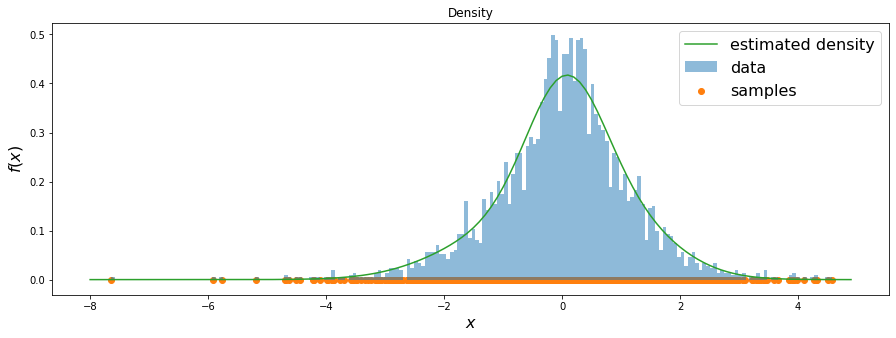

In [344]:
# Take the average of the parameter estimates
w_bar = np.nanmean(w_out, axis = 0)
mu_bar = np.nanmean(mu_out, axis = 0)
sigma_bar = np.nanmean(sigma_out, axis = 0)

x_arr = np.arange(-8, 5, 0.1)
y_est = pdf(x_arr, w_bar, mu_bar, sigma_bar)

# Plot final estimate of density
fig, ax = plt.subplots(figsize = (15,5))

ax.hist(train['x'], 200, density = True, alpha = 0.50, label = 'data')

ax.plot(x_arr, y_est, color = colors[2], label = 'estimated density')

ax.scatter(train['x'] , np.zeros(len(train['x'])), color = colors[1], label = 'samples')

ax.set_title('Density')
ax.set_xlabel(r'$x$', fontsize = 16)
ax.set_ylabel(r'$f(x)$', fontsize = 16)
ax.legend(fontsize = 16)

plt.show()

The statistics below suggest that our VaR calculation may be too conservative. However, slightly more than 5 percent of trading days were exceptions, suggesting that our model was not sufficiently conservative when estimating the left-trail.

In [345]:
def get_results(data, w, mu, sigma):
    
    results = pd.DataFrame(index = ['data', 'approx'])

    # Take a look at the mean
    results.loc['data', 'mean'] = train['x'].mean()

    mu = integrate.quad(lambda x: x * pdf(x, w_bar, mu_bar, sigma_bar), -10, 10)[0]
    results.loc['approx', 'mean'] = mu

    # Take a look at the sd
    results.loc['data', 'sd'] = train['x'].std()

    sd = np.sqrt(integrate.quad(lambda x: (x - mu)**2 * pdf(x, w_bar, mu_bar, sigma_bar), -10, 10))[0]
    results.loc['approx', 'sd'] = sd

    # Take a look at the skew
    results.loc['data', 'skew'] = train['x'].skew()

    skew = integrate.quad(lambda x: ((x - mu)/sd)**3 * pdf(x, w_bar, mu_bar, sigma_bar), -10, 10)[0]
    results.loc['approx', 'skew'] = skew

    # Take a look at the the kurtosis
    results.loc['data', 'kurtosis'] = train['x'].kurtosis()

    kurtosis = integrate.quad(lambda x: ((x - mu)/sd)**4 * pdf(x, w_bar, mu_bar, sigma_bar), -10, 10)[0]
    results.loc['approx', 'kurtosis'] = kurtosis

    return results

get_results(train, w_bar, mu_bar, sigma_bar)

,mean,sd,skew,kurtosis
data,0.021420,1.150132,-0.327948,2.147522
approx,0.026311,1.114738,-0.247751,3.628122


The fraction of days each year which were exceptions was a substantial improvement from our simipler model.

In [346]:
# Get the fraction of yearly exceptions
train['Frac_Excp'] = train.groupby(train['Date'].dt.year)['Exception'].transform('mean')
train['Frac_Excp_norm'] = train.groupby(train['Date'].dt.year)['Excep_norm'].transform('mean')

train[['Frac_Excp', 'Frac_Excp_norm']].describe()

/Users/charlesrambo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/charlesrambo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Frac_Excp,Frac_Excp_norm
count,3481.000000,3481.000000
mean,0.053433,0.071244
std,0.009569,0.038319
min,0.035714,0.014493
25%,0.047619,0.043307
50%,0.051587,0.071429
75%,0.059524,0.092742
max,0.075697,0.134921


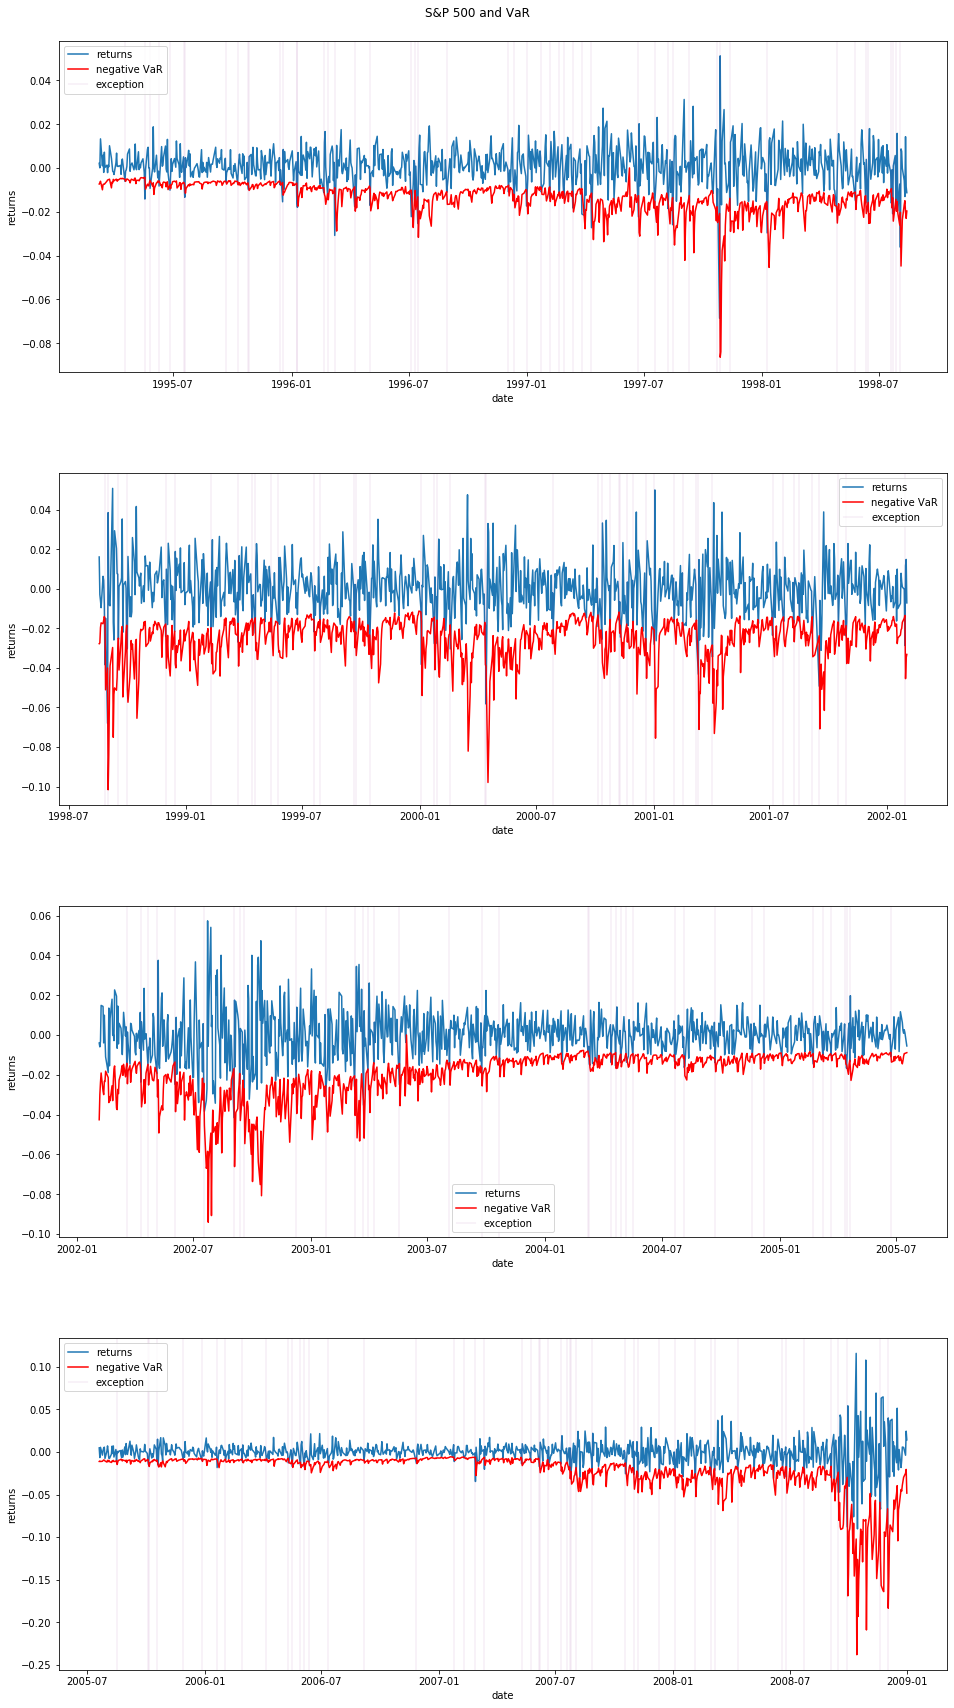

In [347]:
# Number of rows
k = 4

# Plot returns
n = len(train)/k

fig, ax = plt.subplots(k, 1, figsize = (15,25))

for i in range(k):

    ax[i].plot(train.loc[(i * n):(i * n + n - 1), 'Date'], train.loc[(i * n):(i * n + n - 1), 'Ret'], 
               label = 'returns')
    ax[i].plot(train.loc[(i * n):(i * n + n - 1), 'Date'], 0 - train.loc[(i * n):(i * n + n - 1), 'VaR'], 
               color = 'red', label = 'negative VaR')
    ax[i].plot([], [], label = "exception", color = 'purple', linewidth = 0.1)
    ax[i].set_xlabel('date') 
    ax[i].set_ylabel('returns') 
    ax[i].legend()
    
    for j in range(int(i * n), int(i * n + n)):

        if train.loc[j, 'Exception'] == True:
            
            ax[i].axvline(x = train.loc[j, 'Date'], color = 'purple', linewidth = 0.1)
            
fig.suptitle('S&P 500 and VaR')
plt.tight_layout(pad = 7)

plt.show()

# Test Set Results
The performance of our VaR model was almost the same out-of-sample. This suggests we do not have an over-fitting problem. However, the statistics for the mixture model show that our VaR estimate may be too conservative. 

In [348]:
# We will use three Kernels again
K = 3

# Save results
w_out = np.zeros((1, K))
mu_out = np.zeros((1, K))
sigma_out = np.zeros((1, K))

# Record window
window = 126

for i in test.index[45:]:
    
    start = int(np.max([i - window, 0]))
    stop = i - 1
    
    x = test.loc[start:stop, 'x'].values
    
    w, mu, sigma = cal_em_pars(x)
    
    # Start VaR calculation; still need to denormalize
    test.loc[i, 'VaR'] = 0 - ppf(0.05, w, mu, sigma)
    
    w_out = np.concatenate([w_out, [w]], axis = 0)
    mu_out = np.concatenate([mu_out, [mu]], axis = 0)
    sigma_out = np.concatenate([sigma_out, [sigma]], axis = 0)

# Remove row of zeros
w_out = w_out[1:]
mu_out = mu_out[1:]
sigma_out = sigma_out[1:]
    
# Denormalize
test['VaR'] = test['sigma'] * test['VaR']
    
# Obtain days when there is an exception
test['Exception'] = 0 - test['VaR'] > test['Ret']

test.dropna(axis = 0, inplace = True)
test.reset_index(drop = True, inplace = True)

test.head()

/Users/charlesrambo/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/charlesrambo/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/charlesrambo/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1782: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarra

,Date,Ret,sigma,Excep_norm,x,VaR,Exception
0,2009-01-13,0.001758,0.018331,False,0.095904,0.048927,False
1,2009-01-14,-0.033460,0.012476,True,-2.681930,0.033226,True
2,2009-01-15,0.001329,0.023024,False,0.057731,0.064076,False
3,2009-01-16,0.007562,0.015256,False,0.495651,0.042787,False
4,2009-01-20,-0.052816,0.011661,True,-4.529486,0.032194,True


Once again, we note this graph is for illustration purposes only. The parameters can change over time.

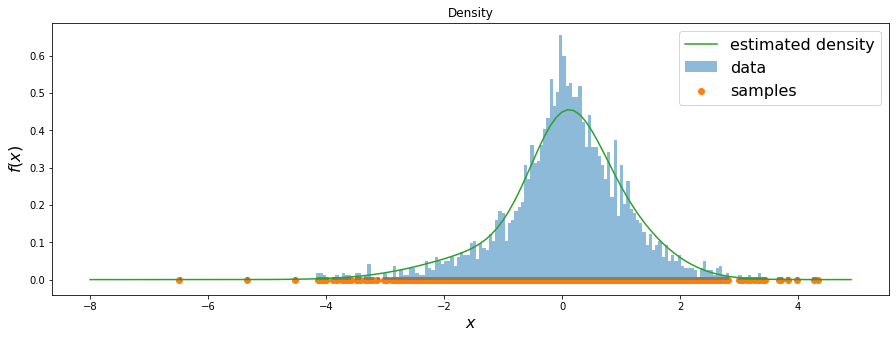

In [349]:
# Reorder the parameters based on the order of mu
w_out, mu_out, sigma_out = reorder_pars(w_out, mu_out, sigma_out)

# Calculate the means
w_bar = np.nanmean(w_out, axis = 0)
mu_bar = np.nanmean(mu_out, axis = 0)
sigma_bar = np.nanmean(sigma_out, axis = 0)

x_arr = np.arange(-8, 5, 0.1)
y_est = pdf(x_arr, w_bar, mu_bar, sigma_bar)

# Plot final estimate of density
fig, ax = plt.subplots(figsize = (15,5))

ax.hist(test['x'], 200, density = True, alpha = 0.50, label = 'data')
ax.plot(x_arr, y_est, color = colors[2], label = 'estimated density')
ax.scatter(test['x'] , np.zeros(len(test['x'])), color = colors[1], label = 'samples')

ax.set_title('Density')
ax.set_xlabel(r'$x$', fontsize = 16)
ax.set_ylabel(r'$f(x)$', fontsize = 16)
ax.legend(fontsize = 16)

plt.show()

In [350]:
get_results(test, w_bar, mu_bar, sigma_bar)

,mean,sd,skew,kurtosis
data,0.021420,1.150132,-0.327948,2.147522
approx,0.046215,1.069458,-0.513986,4.041816


In [351]:
# Get the fraction of yearly exceptions
test['Frac_Excp_test'] = test.groupby(train['Date'].dt.year)['Exception'].transform('mean')
test['Frac_Excp_norm'] = test.groupby(test['Date'].dt.year)['Excep_norm'].transform('mean')

Exceptions = test[['Frac_Excp_test', 'Frac_Excp_norm']].describe()
Exceptions['Frac_Excp_train'] = train['Frac_Excp'].describe()
Exceptions = Exceptions[['Frac_Excp_train', 'Frac_Excp_test', 'Frac_Excp_norm']]
Exceptions

/Users/charlesrambo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/charlesrambo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Frac_Excp_train,Frac_Excp_test,Frac_Excp_norm
count,3481.000000,3014.000000,3014.000000
mean,0.053433,0.050763,0.060053
std,0.009569,0.012605,0.023190
min,0.035714,0.000000,0.015936
25%,0.047619,0.039683,0.039683
50%,0.051587,0.051587,0.051587
75%,0.059524,0.057971,0.079365
max,0.075697,0.067729,0.095238


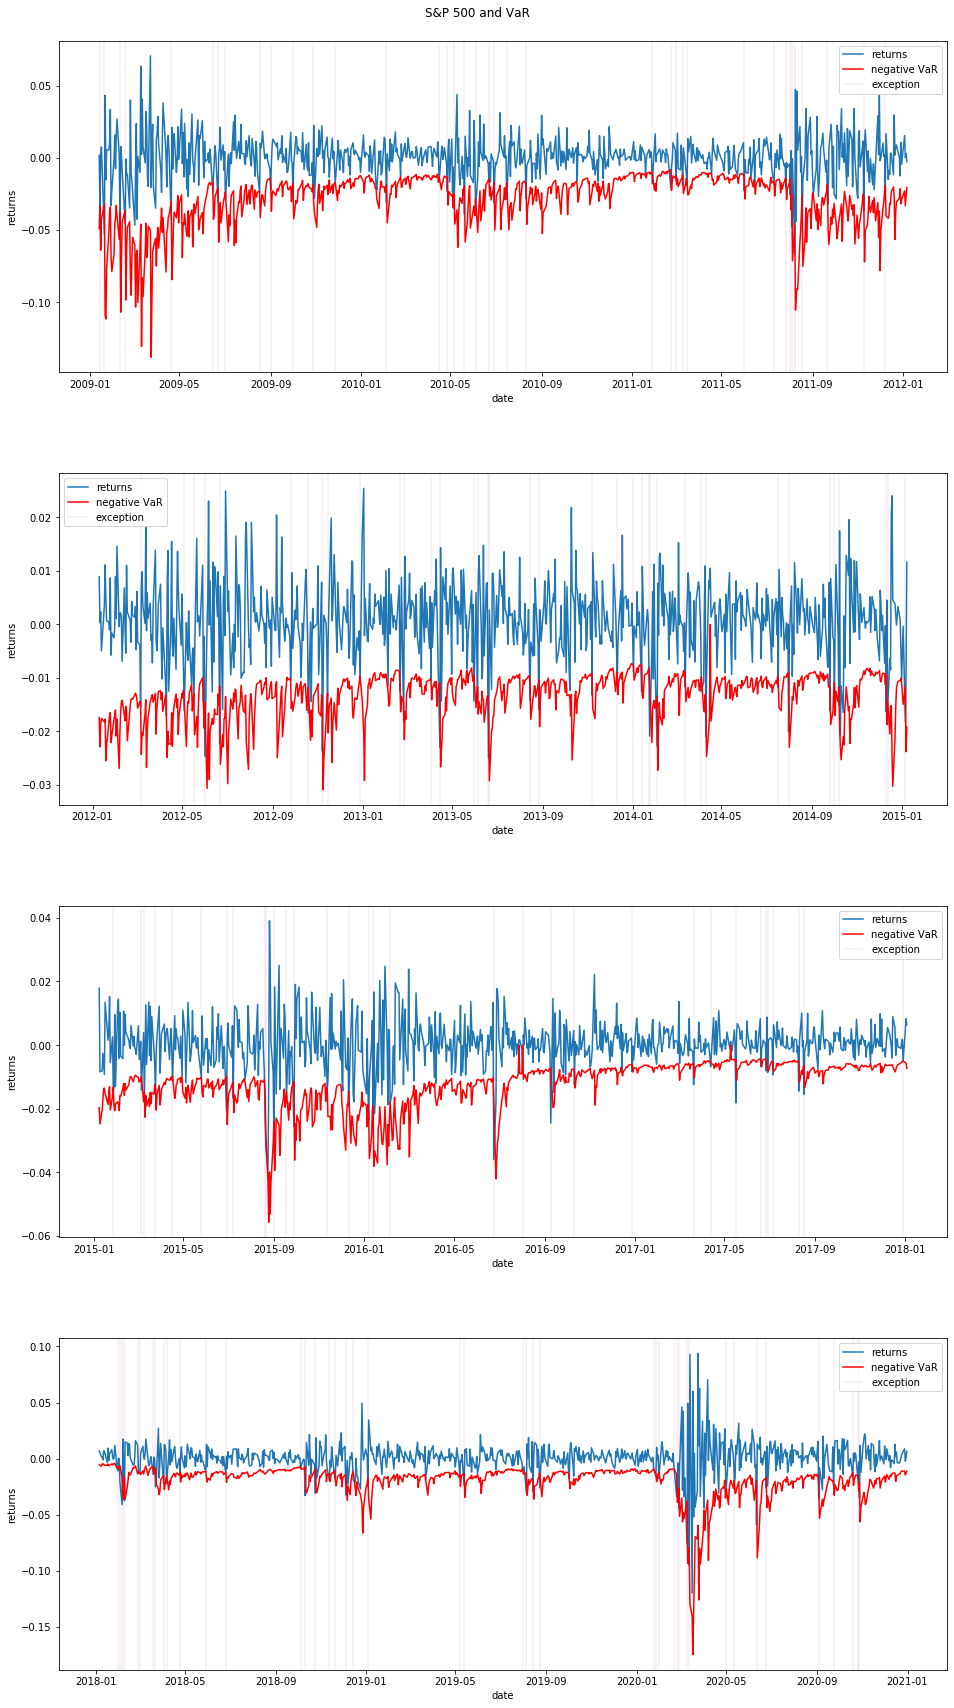

In [352]:
# Number of rows
k = 4

# Plot returns
n = len(test)/k

fig, ax = plt.subplots(k, 1, figsize = (15,25))

for i in range(k):

    ax[i].plot(test.loc[(i * n):(i * n + n - 1), 'Date'], test.loc[(i * n):(i * n + n - 1), 'Ret'], label = 'returns')
    ax[i].plot(test.loc[(i * n):(i * n + n - 1), 'Date'], 0 - test.loc[(i * n):(i * n + n - 1), 'VaR'], color = 'red', 
               label = 'negative VaR')
    ax[i].plot([], [], label = "exception", color = 'purple', linewidth = 0.1)
    ax[i].set_xlabel('date') 
    ax[i].set_ylabel('returns') 
    ax[i].legend()
    
    for j in range(int(i * n), int(i * n + n)):

        if test.loc[j, 'Exception'] == True:
            
            ax[i].axvline(x = test.loc[j, 'Date'], color = 'purple', linewidth = 0.1)
            
fig.suptitle('S&P 500 and VaR')
plt.tight_layout(pad = 7)

plt.show()